# Model Building and Analysis

We will now start creating the Machine Learning models that will help us predict the sales for the specified period. We will begin with a Global model (that is including both products) and will drill-down the data to compare metrics.

In [1]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error


# Libraries for Forecasting
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
import datetime
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from pycaret.regression import *

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

#### The following number helps us debug the code without having to wait too long for a complete training. Set it to 100 for the best model results, set it to 2 for faster training

In [2]:
numero = 100

In [3]:
df_repsol = pd.read_csv('df_repsol.csv', index_col=1).drop(columns = ["Unnamed: 0"])
df_repsol["station"] = df_repsol["station"].str[2:]
df_repsol["station"] = df_repsol["station"].astype(int)

In [4]:
le = preprocessing.LabelEncoder()
df_repsol['municipality'] = le.fit_transform(df_repsol["municipality"].values)

In [5]:
df_repsol['producto'] = 0
df_repsol.loc[df_repsol['product'] == '95', 'producto'] = 1

In [6]:
columns_strings = df_repsol.dtypes[df_repsol.dtypes == "object"].index
columns_strings

Index(['product', 'horaracha', 'horatmax', 'horatmin', 'coordinates',
       'provinces'],
      dtype='object')

In [7]:
def r2_rmse(data):
    r2 = r2_score(data['sales_norm'], data['Label'] )
    mae =  mean_absolute_error(data['sales_norm'], data['Label'])
    return pd.Series(dict(mae = mae, r2 = r2))

In [8]:
df_repsol_model = df_repsol.drop(columns = columns_strings)
df_repsol_model.dropna(inplace = True)

In [9]:
global_train = df_repsol_model.loc[(df_repsol_model.index >= '2016-01-01')
                     & (df_repsol_model.index <= '2018-12-31')]

global_test = df_repsol_model.loc[(df_repsol_model.index >= '2019-01-01')
                     & (df_repsol_model.index <= '2019-01-31')]

## 1. Global model

We then create a Global Model by testing diferent algorithms such as Lightgbm, Xgboost and Random Forest Regressor

In [10]:
df_repsol_model = df_repsol.drop(columns = columns_strings)
df_repsol_model.dropna(inplace = True)

In [11]:
global_train = df_repsol_model.loc[(df_repsol_model.index >= '2016-01-01')
                     & (df_repsol_model.index <= '2018-12-31')]

global_test = df_repsol_model.loc[(df_repsol_model.index >= '2019-01-01')
                     & (df_repsol_model.index <= '2019-01-31')]

In [12]:
X_train_global = global_train.drop("sales_norm", axis=1)
Y_train_global = global_train["sales_norm"]

X_test_global = global_test.drop("sales_norm", axis=1)
Y_test_global = global_test["sales_norm"]

In [13]:
setup1 = setup(data = global_train,  target = "sales_norm", silent = True) 

,Description,Value
0,session_id,8677
1,Target,sales_norm
2,Original Data,"(24987, 80)"
3,Missing Values,False
4,Numeric Features,65
5,Categorical Features,14
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(17490, 103)"


In [14]:
best_global = compare_models(sort="R2", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en", 'xgboost'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0447,0.0041,0.0644,0.9230,0.0449,0.2126,0.4550
et,Extra Trees Regressor,0.0467,0.0047,0.0684,0.9132,0.0476,0.2208,8.1290
rf,Random Forest Regressor,0.0485,0.0053,0.0725,0.9024,0.0508,0.2391,9.9870
gbr,Gradient Boosting Regressor,0.0560,0.0071,0.0840,0.8689,0.0587,0.2885,3.1450
lr,Linear Regression,0.0650,0.0090,0.0950,0.8327,0.0668,0.3517,0.7290
ridge,Ridge Regression,0.0650,0.0090,0.0949,0.8327,0.0668,0.3520,0.0320
br,Bayesian Ridge,0.0650,0.0090,0.0949,0.8327,0.0668,0.3520,0.2530
omp,Orthogonal Matching Pursuit,0.0650,0.0091,0.0956,0.8304,0.0672,0.3527,0.0330
dt,Decision Tree Regressor,0.0681,0.0105,0.1023,0.8058,0.0713,0.2844,0.2450
ada,AdaBoost Regressor,0.0934,0.0134,0.1159,0.7510,0.0842,0.6132,2.8020


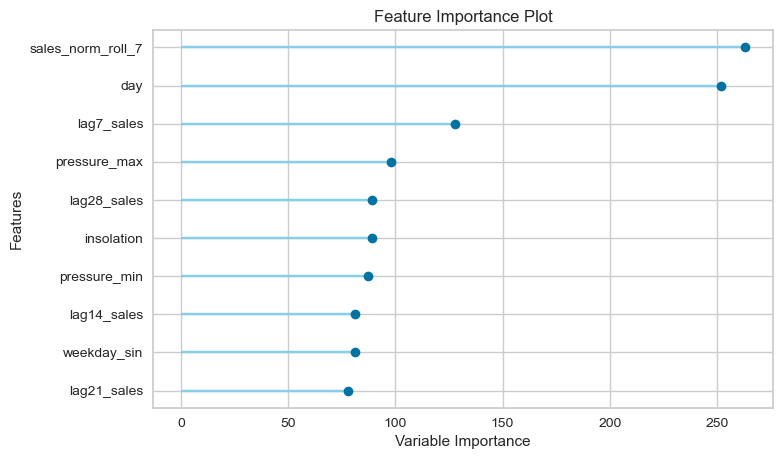

In [15]:
plot_model(best_global, plot='feature')

#### A LightGBM Global model improves the metrics significantly providing a 49% in the test set. However, it is still struggling to predict GOA sales.

In [16]:
predictions_train_global = predict_model(best_global, data= global_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0401,0.0032,0.0568,0.9406,0.0397,0.2326


In [17]:
predictions_train_global.groupby('producto').apply(r2_rmse).reset_index()

,producto,mae,r2
0,0,0.055825,0.808013
1,1,0.024415,0.883791


In [18]:
predictions_test_global = predict_model(best_global, data= global_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0550,0.0072,0.0847,0.8289,0.0630,0.4219


In [19]:
predictions_test_global.groupby('producto').apply(r2_rmse).reset_index()

,producto,mae,r2
0,0,0.084371,0.524643
1,1,0.025714,0.856410


#### Tuning the Global model using a custom grid and Optuna does not provide better results.

In [20]:
lgbm_params = {'num_leaves': np.arange(10,200,10),
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'learning_rate': np.arange(0.1,1,0.1),
               'n_jobs': [-1]
                        }

In [21]:
tuned_global = tune_model(best_global, custom_grid = lgbm_params, n_iter = numero, search_library = "optuna", optimize="r2", tuner_verbose = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0434,0.0040,0.0635,0.9249,0.0448,0.2236
1,0.0445,0.0041,0.0637,0.9251,0.0438,0.1810
2,0.0441,0.0040,0.0633,0.9270,0.0437,0.2319
3,0.0424,0.0037,0.0605,0.9326,0.0420,0.2033
4,0.0414,0.0035,0.0593,0.9368,0.0410,0.2072
5,0.0442,0.0040,0.0631,0.9256,0.0439,0.1802
6,0.0435,0.0040,0.0630,0.9237,0.0442,0.1844
7,0.0425,0.0037,0.0609,0.9320,0.0423,0.1970
8,0.0437,0.0040,0.0630,0.9266,0.0430,0.1565


In [22]:
predictions_train_tuned_global = predict_model(tuned_global, data= global_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0362,0.0026,0.0510,0.9522,0.0357,0.2036


In [23]:
predictions_train_tuned_global.groupby('producto').apply(r2_rmse).reset_index()

,producto,mae,r2
0,0,0.049188,0.848877
1,1,0.023169,0.895473


In [24]:
predictions_test_tuned_global = predict_model(tuned_global, data= global_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0546,0.0071,0.0840,0.8317,0.0625,0.4166


In [25]:
predictions_test_tuned_global.groupby('producto').apply(r2_rmse).reset_index()

,producto,mae,r2
0,0,0.083884,0.533525
1,1,0.025267,0.854591


# 2. One model for each product

We explore the possibility of a more granular model for each product by drilling down the data a bit further.

In [26]:
df_repsol_GOA = df_repsol[df_repsol["product"]=="GOA"]
df_repsol_95 = df_repsol[df_repsol["product"]=="95"]

In [27]:
df_repsol_GOA = df_repsol_GOA.drop(columns = columns_strings)
df_repsol_95 = df_repsol_95.drop(columns = columns_strings)

In [28]:
df_repsol_95.dropna(inplace = True)
df_repsol_GOA.dropna(inplace = True)

## 2.1 95 Product-specific model

#### Splitting the 95 dataset intro train and test

In [29]:
N95_train = df_repsol_95.loc[(df_repsol_95.index >= '2016-01-01')
                     & (df_repsol_95.index <= '2018-12-31')]

N95_test = df_repsol_95.loc[(df_repsol_95.index >= '2019-01-01')
                     & (df_repsol_95.index <= '2019-01-31')]

In [30]:
X_train_95 = N95_train.drop("sales_norm", axis=1)
Y_train_95 = N95_train["sales_norm"]

X_test_95 = N95_test.drop("sales_norm", axis=1)
Y_test_95 = N95_test["sales_norm"]

### Pycaret - selecting the best algorithm

In [31]:
setup1 = setup(data = N95_train,  target = "sales_norm", silent= True) 

,Description,Value
0,session_id,2534
1,Target,sales_norm
2,Original Data,"(12488, 80)"
3,Missing Values,False
4,Numeric Features,65
5,Categorical Features,14
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8741, 105)"


In [32]:
best_95 = compare_models(sort="R2", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en", 'rf', 'et'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0242,0.0010,0.0320,0.8833,0.0265,0.1861,0.2700
xgboost,Extreme Gradient Boosting,0.0254,0.0011,0.0338,0.8704,0.0280,0.1913,1.1280
gbr,Gradient Boosting Regressor,0.0259,0.0012,0.0342,0.8671,0.0283,0.1973,1.6690
lr,Linear Regression,0.0285,0.0014,0.0375,0.8398,0.0311,0.2162,0.0720
br,Bayesian Ridge,0.0285,0.0014,0.0376,0.8397,0.0311,0.2168,0.1430
omp,Orthogonal Matching Pursuit,0.0286,0.0014,0.0376,0.8394,0.0312,0.2158,0.0340
ridge,Ridge Regression,0.0286,0.0014,0.0377,0.8382,0.0313,0.2182,0.0290
ada,AdaBoost Regressor,0.0321,0.0017,0.0408,0.8103,0.0341,0.2897,1.1810
dt,Decision Tree Regressor,0.0367,0.0024,0.0491,0.7253,0.0406,0.2662,0.1340
dummy,Dummy Regressor,0.0770,0.0088,0.0939,-0.0013,0.0786,0.7379,0.0210


In [33]:
evaluate_model(best_95)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

#### The 95 model seems to be performing well for both training and testing data. The R2 in the test set is 87%.

In [34]:
predictions_train_95 = predict_model(best_95, data= N95_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0205,0.0007,0.0273,0.9161,0.0227,0.1596


In [35]:
predictions_test_95 = predict_model(best_95, data= N95_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0247,0.0011,0.0335,0.8623,0.0285,0.2341


In [36]:
predictions_train_95.groupby('station').apply(r2_rmse).reset_index()

,station,mae,r2
0,1,0.014294,0.579885
1,2,0.024545,0.598228
2,3,0.020575,0.657726
3,4,0.016072,0.533553
4,5,0.015706,0.603330
5,6,0.027133,0.695824
6,7,0.028829,0.545173
7,8,0.017403,0.585474
8,9,0.017609,0.564347
9,10,0.025947,0.639354


**The most important features indicate weekly seasonality.**

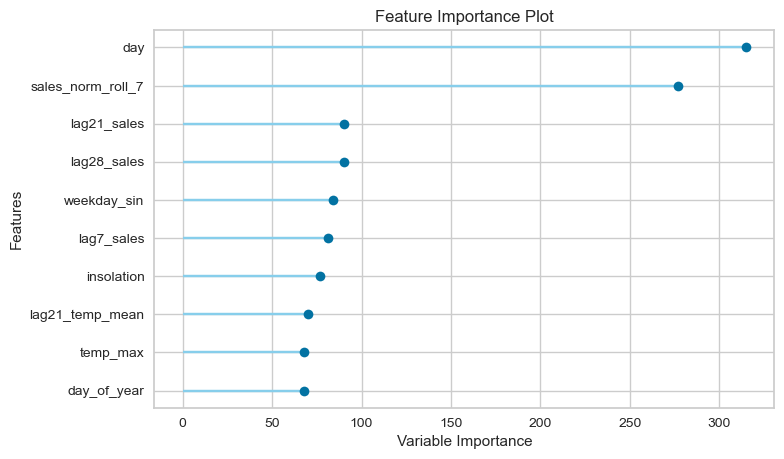

In [37]:
plot_model(best_95, plot='feature')

**The errors in the test set are larger than in the train set.**

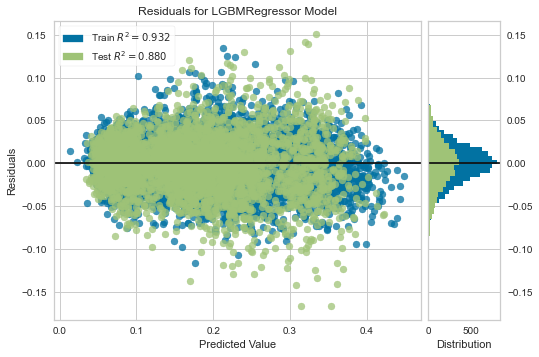

In [38]:
best_95 = create_model(best_95)

# plot model
plot_model(best_95, plot = 'residuals')

**We extract the hyperparameters used in the best model.**

In [39]:
plot_model(best_95, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


#### Let's try Tuning the model. This worsens the model as we obtain an R2 of 82% in the test set.

In [40]:
lgbm_params = {'num_leaves': np.arange(10,200,10),
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'learning_rate': np.arange(0.1,1,0.1),
               'n_jobs': [-1]
                        }

In [41]:
tuned_model_95 = tune_model(best_95, custom_grid = lgbm_params, n_iter = numero, search_library = "optuna", optimize="r2", tuner_verbose = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0237,0.0010,0.0317,0.8818,0.0264,0.1814
1,0.0250,0.0011,0.0326,0.8929,0.0268,0.1883
2,0.0234,0.0009,0.0307,0.8939,0.0255,0.1793
3,0.0253,0.0011,0.0338,0.8719,0.0279,0.1822
4,0.0242,0.0010,0.0322,0.8806,0.0267,0.1925
5,0.0248,0.0011,0.0335,0.8728,0.0277,0.1837
6,0.0242,0.0010,0.0317,0.8806,0.0264,0.2349
7,0.0257,0.0011,0.0338,0.8737,0.0280,0.1922
8,0.0240,0.0010,0.0318,0.8815,0.0262,0.1684


In [42]:
predictions_train_tuned_95 = predict_model(tuned_model_95, data= N95_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0220,0.0008,0.0291,0.9048,0.0241,0.1696


In [43]:
predictions_test_tuned_95 = predict_model(tuned_model_95, data= N95_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0252,0.0012,0.0342,0.8565,0.0290,0.2367


## 2.2 GOA Product

#### Splitting the GOA dataset intro train and test

In [44]:
GOA_train = df_repsol_GOA.loc[(df_repsol_GOA.index >= '2016-01-01')
                     & (df_repsol_GOA.index <= '2018-12-31')]

GOA_test = df_repsol_GOA.loc[(df_repsol_GOA.index >= '2019-01-01')
                     & (df_repsol_GOA.index <= '2019-01-31')]

In [45]:
X_train_GOA = GOA_train.drop("sales_norm", axis=1)
Y_train_GOA = GOA_train["sales_norm"]

X_test_GOA = GOA_test.drop("sales_norm", axis=1)
Y_test_GOA = GOA_test["sales_norm"]

### Pycaret - selecting the best algorithm

In [46]:
setup1 = setup(data = GOA_train,  target = "sales_norm", fold_strategy = 'timeseries', silent = True)

,Description,Value
0,session_id,5535
1,Target,sales_norm
2,Original Data,"(12499, 80)"
3,Missing Values,False
4,Numeric Features,65
5,Categorical Features,14
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8749, 106)"


In [47]:
best_GOA = compare_models(sort="R2", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en", 'rf', 'et', 'ada'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0708,0.0091,0.0945,0.6765,0.0637,0.3944,0.2340
xgboost,Extreme Gradient Boosting,0.0734,0.0097,0.0975,0.6535,0.0655,0.3798,0.7260
gbr,Gradient Boosting Regressor,0.0820,0.0122,0.1103,0.5649,0.0750,0.5881,1.0720
ridge,Ridge Regression,0.0930,0.0156,0.1249,0.4436,0.0851,0.7171,0.0240
lr,Linear Regression,0.0936,0.0157,0.1253,0.4404,0.0852,0.7007,0.0420
br,Bayesian Ridge,0.0930,0.0157,0.1253,0.4404,0.0854,0.7251,0.0730
omp,Orthogonal Matching Pursuit,0.0927,0.0158,0.1257,0.4369,0.0856,0.7168,0.0260
dt,Decision Tree Regressor,0.1084,0.0229,0.1504,0.1835,0.1020,0.6186,0.0910
dummy,Dummy Regressor,0.1338,0.0281,0.1676,-0.0010,0.1126,0.9841,0.0210


**Using a product specific algorithm improves the GOA metrics compared to the global. However the R2 is still low in the test set with an R2 of 46%.**

In [48]:
predictions_train_GOA = predict_model(best_GOA, data= GOA_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0536,0.0050,0.0704,0.8246,0.0469,0.2322


In [49]:
predictions_test_GOA = predict_model(best_GOA, data= GOA_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0836,0.0138,0.1174,0.5024,0.0868,0.6380


**GOA Feature importance**

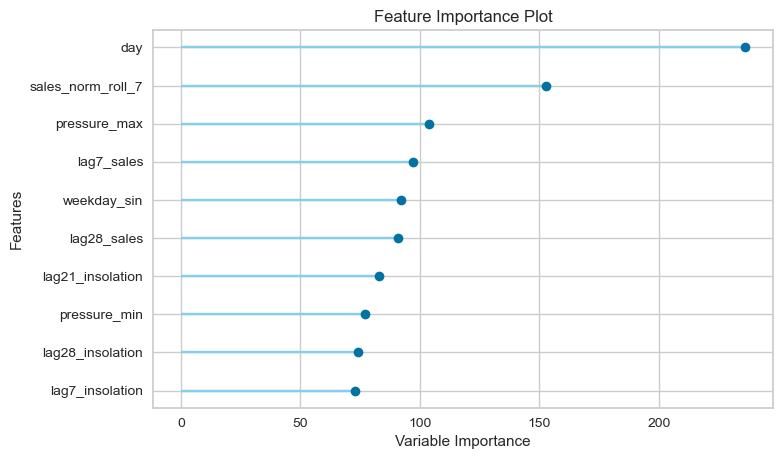

In [50]:
plot_model(best_GOA, plot='feature')

**The test errors are more dispersed than for the 95 product.**

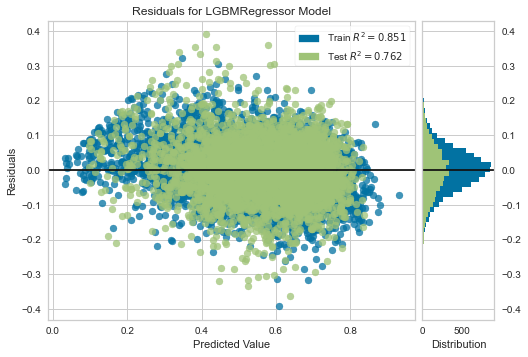

In [51]:
best_GOA = create_model(best_GOA)

# plot model
plot_model(best_GOA, plot = 'residuals')

**We extract the hyperparameters for the best GOA model.**

In [52]:
# plot model
plot_model(best_GOA, plot = 'parameter')

,Parameters
boosting_type,gbdt
class_weight,None
colsample_bytree,1.0
importance_type,split
learning_rate,0.1
max_depth,-1
min_child_samples,20
min_child_weight,0.001
min_split_gain,0.0
n_estimators,100


#### Let's try Tuning the model. This does not improve the results on the test set.

In [53]:
lgbm_params = {'num_leaves': np.arange(10,200,10),
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'learning_rate': np.arange(0.1,1,0.1),
               'n_jobs': [-1]
                        }

In [54]:
tuned_model_GOA = tune_model(best_GOA, custom_grid = lgbm_params, n_iter = numero, search_library = "optuna", optimize="r2", tuner_verbose = 100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0920,0.0152,0.1232,0.4640,0.0833,0.3676
1,0.0775,0.0109,0.1045,0.5913,0.0704,0.2329
2,0.0790,0.0113,0.1061,0.6215,0.0723,0.2531
3,0.0746,0.0096,0.0981,0.6631,0.0661,0.2261
4,0.0670,0.0078,0.0883,0.7021,0.0589,1.1503
5,0.0660,0.0074,0.0861,0.7248,0.0574,0.2490
6,0.0662,0.0080,0.0897,0.7023,0.0608,0.2811
7,0.0637,0.0069,0.0830,0.7574,0.0547,0.1472
8,0.0626,0.0072,0.0846,0.7601,0.0566,0.8049


In [55]:
predictions_train_tuned_GOA = predict_model(tuned_model_GOA, data= GOA_train)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0524,0.0047,0.0687,0.8332,0.0456,0.1927


In [56]:
predictions_test_tuned_GOA = predict_model(tuned_model_GOA, data= GOA_test)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0852,0.0133,0.1152,0.5210,0.0839,0.5747


In [57]:
predictions_test_tune_GOA_wo_1st = predict_model(tuned_model_GOA, data= GOA_test.loc[GOA_test.index>"2019-01-08"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0692,0.0081,0.0898,0.5661,0.0600,0.1469


# 2.2.1 GOA predictions investigation

### Plot the predictions for each station for the GOA product-specific model

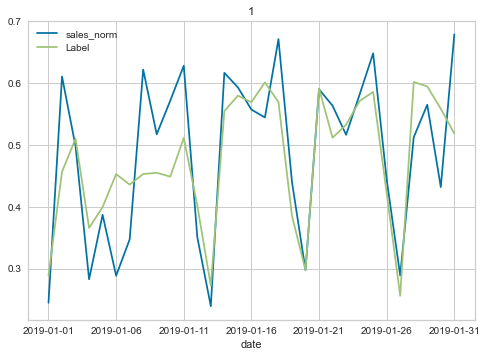

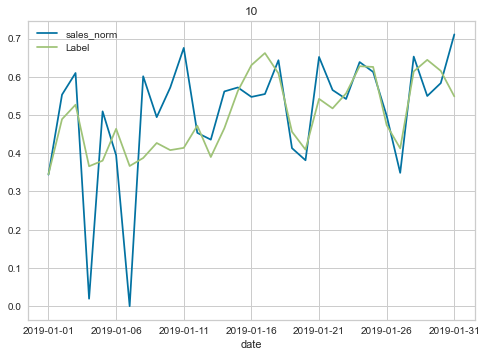

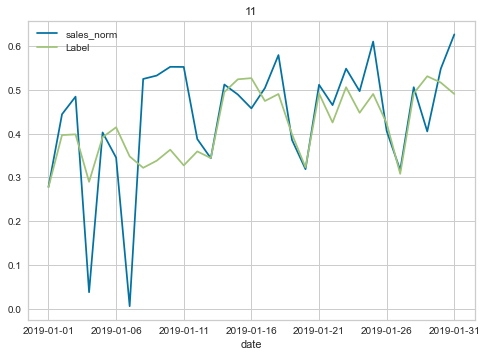

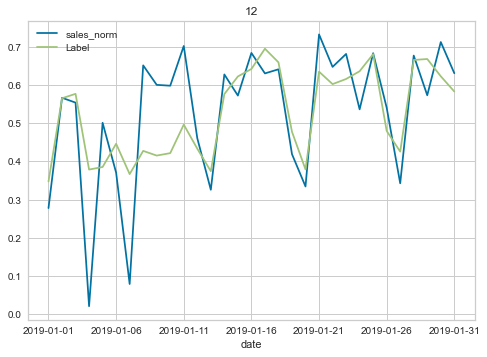

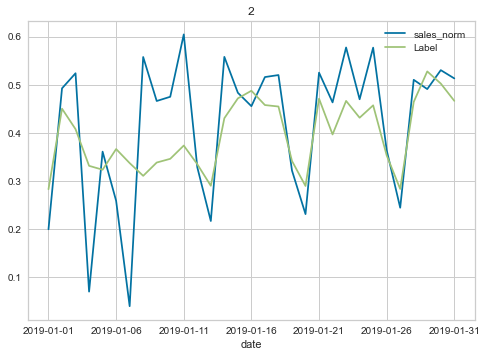

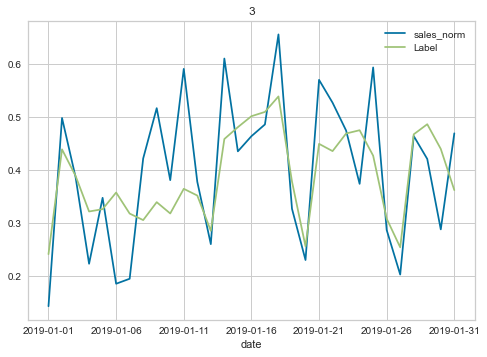

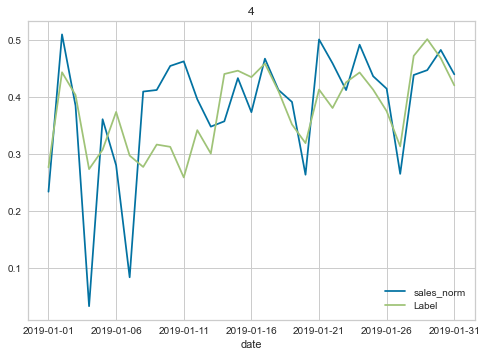

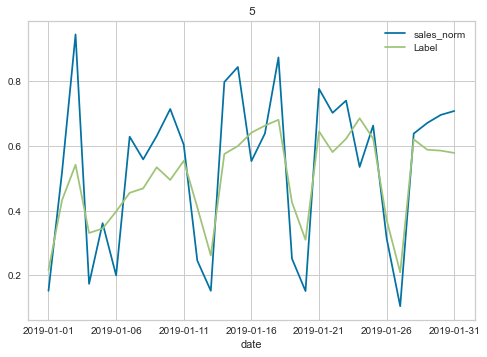

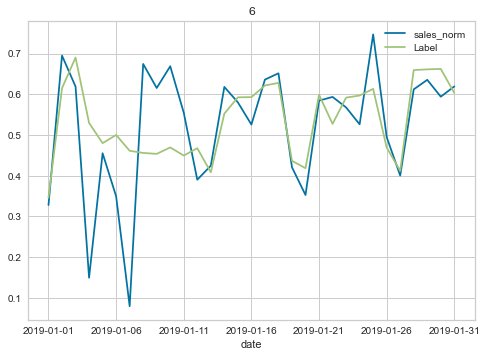

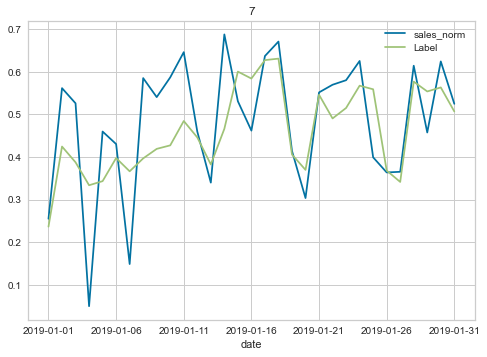

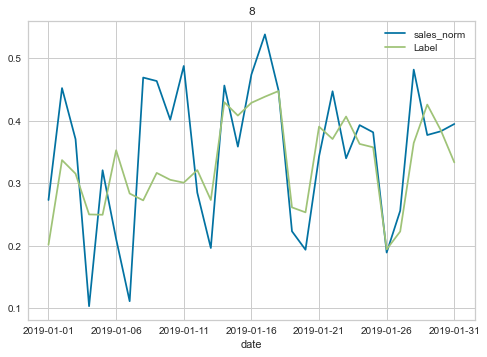

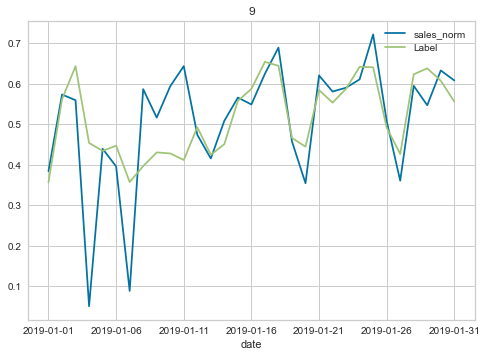

In [59]:
for st in predictions_test_tuned_GOA["station"].unique().tolist():
    predictions_test_tuned_GOA[predictions_test_tuned_GOA["station"]==st][["sales_norm", "Label"]].plot(title=st)


**As seen in the predictions plots, the model is struggling to predict the first week of January. we conclude that this  is due to Three Kings day holiday, we therefore remove the first week of January. The R2 improves significantly.**

In [60]:
predictions_test_GOA_wo = predict_model(best_GOA, data= GOA_test.loc[GOA_test.index>"2019-01-08"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0645,0.0067,0.0821,0.6372,0.0549,0.1391


**We try tuning the model that does not predict the first week.**

In [61]:
predictions_test_tune_GOA_wo_1st = predict_model(tuned_model_GOA, data= GOA_test.loc[GOA_test.index>"2019-01-08"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0692,0.0081,0.0898,0.5661,0.0600,0.1469


### Compare this first 8 days over the years to see if the behaviour is similar

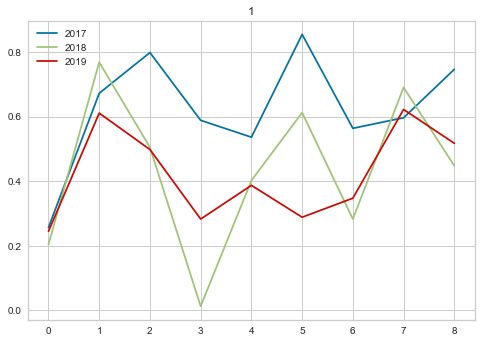

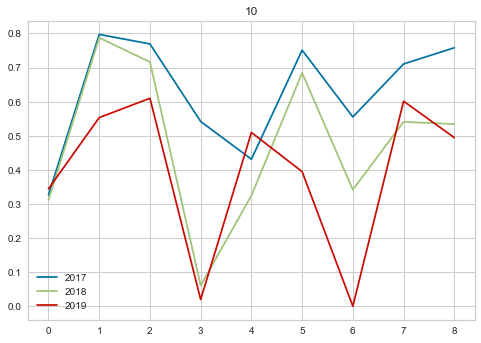

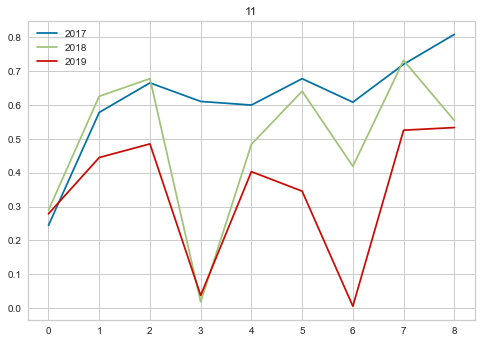

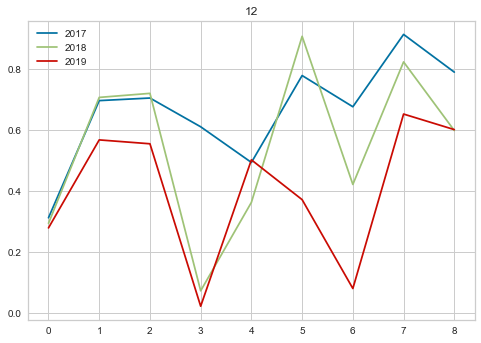

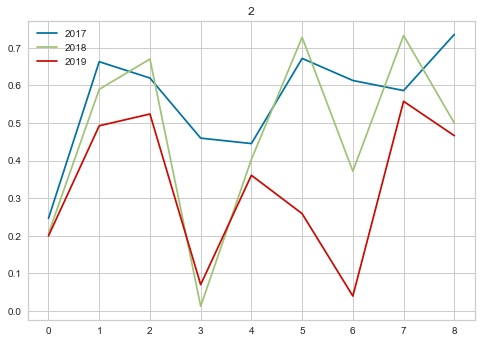

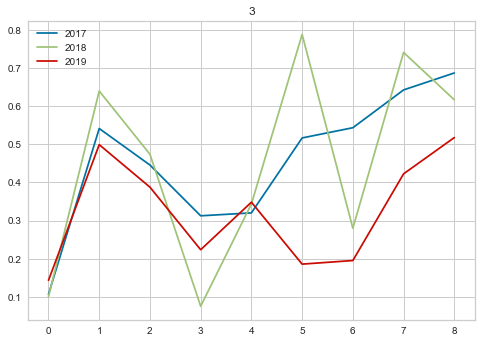

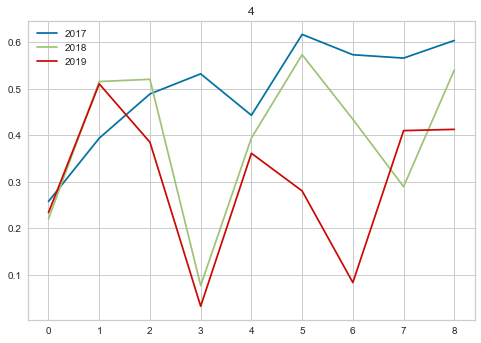

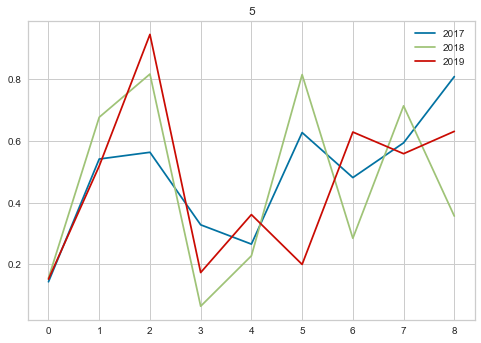

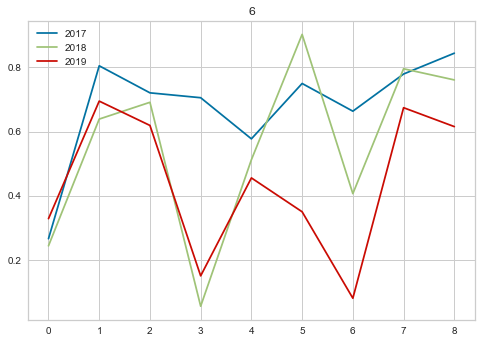

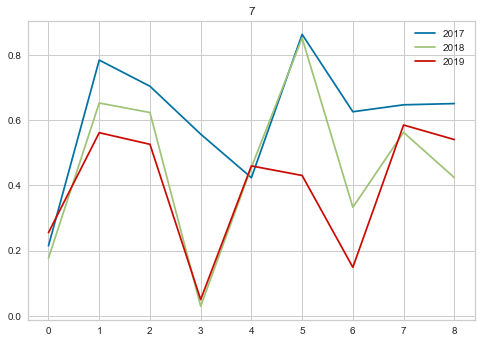

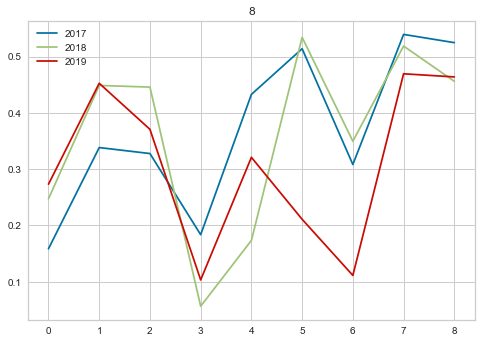

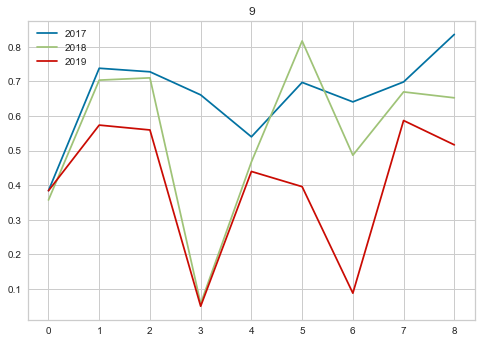

In [63]:
for st in predictions_test_tuned_GOA["station"].unique().tolist():
    f, ax = plt.subplots()
    for year in ["2017", "2018", "2019"]:
        df_repsol_GOA[df_repsol_GOA["station"]==st].loc[f"{year}-01-01":f"{year}-01-09"].reset_index()["sales_norm"].plot(title=st, ax=ax, label=year)
        ax.legend()


# 3. Station-specific GOA models

### Calculating the MAE from the Global models for GOA and the GOA models for each station.

#### Global Model MAEs for GOA

In [64]:
from sklearn.metrics import mean_absolute_error
counter = GOA_train.station.unique()
d_global_maes = {}
d_global_tuned_maes = {}
d_global_GOA_maes = {}
d_global_GOA_tuned_maes = {}

for i in counter:
    d_global_maes["Global_MAE_{0}".format(i)] = mean_absolute_error(predictions_test_global[predictions_test_global['producto'] == 0][predictions_test_global[predictions_test_global['producto'] == 0]['station'] ==i]['sales_norm'], predictions_test_global[predictions_test_global['producto'] == 0][predictions_test_global[predictions_test_global['producto'] == 0]['station'] ==i]['Label'])
    print(f'Station {i} Global GOA MAE: ' +str(mean_absolute_error(predictions_test_global[predictions_test_global['producto'] == 0][predictions_test_global[predictions_test_global['producto'] == 0]['station'] ==i]['sales_norm'], predictions_test_global[predictions_test_global['producto'] == 0][predictions_test_global[predictions_test_global['producto'] == 0]['station'] ==i]['Label'])))

Station 1 Global GOA MAE: 0.06676613937117602
Station 10 Global GOA MAE: 0.08247474267335304
Station 11 Global GOA MAE: 0.07685611273998162
Station 12 Global GOA MAE: 0.07933900423851754
Station 2 Global GOA MAE: 0.0850137719535799
Station 3 Global GOA MAE: 0.08730928308776838
Station 4 Global GOA MAE: 0.06727829783976805
Station 5 Global GOA MAE: 0.13813826712182728
Station 6 Global GOA MAE: 0.09221752287448982
Station 7 Global GOA MAE: 0.08183026103150154
Station 8 Global GOA MAE: 0.07719817322583673
Station 9 Global GOA MAE: 0.07803522810314271


#### Global Tuned Model MAEs for GOA

In [65]:
for i in counter:
    d_global_tuned_maes["Global_tuned_MAE_{0}".format(i)] = mean_absolute_error(predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0][predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0]['station'] ==i]['sales_norm'], predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0][predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0]['station'] ==i]['Label'])
    print(f'Station {i} Global Tuned GOA MAE: ' +str(mean_absolute_error(predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0][predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0]['station'] ==i]['sales_norm'], predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0][predictions_test_tuned_global[predictions_test_tuned_global['producto'] == 0]['station'] ==i]['Label'])))

Station 1 Global Tuned GOA MAE: 0.06352580548443443
Station 10 Global Tuned GOA MAE: 0.08698442992303598
Station 11 Global Tuned GOA MAE: 0.07782931142332218
Station 12 Global Tuned GOA MAE: 0.08239789881614895
Station 2 Global Tuned GOA MAE: 0.08568324511667273
Station 3 Global Tuned GOA MAE: 0.08397689977384762
Station 4 Global Tuned GOA MAE: 0.07065446752932637
Station 5 Global Tuned GOA MAE: 0.1285701559408219
Station 6 Global Tuned GOA MAE: 0.08844679386059964
Station 7 Global Tuned GOA MAE: 0.08343903567673384
Station 8 Global Tuned GOA MAE: 0.07807013051712423
Station 9 Global Tuned GOA MAE: 0.07703465055728206


#### GOA Model MAEs for GOA

In [66]:
for i in counter:
    d_global_GOA_maes["Global_GOA_MAE_{0}".format(i)] = mean_absolute_error(predictions_test_GOA[predictions_test_GOA['station']==i]['sales_norm'], predictions_test_GOA[predictions_test_GOA['station']==i]['Label'])
    print(f'Station {i} GOA MAE: ' +str(mean_absolute_error(predictions_test_GOA[predictions_test_GOA['station']==i]['sales_norm'], predictions_test_GOA[predictions_test_GOA['station']==i]['Label'])))

Station 1 GOA MAE: 0.06249580459743115
Station 10 GOA MAE: 0.08574446953551787
Station 11 GOA MAE: 0.07775504378344947
Station 12 GOA MAE: 0.0837104597399893
Station 2 GOA MAE: 0.0857405519618649
Station 3 GOA MAE: 0.08286286504135397
Station 4 GOA MAE: 0.07534070609872759
Station 5 GOA MAE: 0.12220928242004256
Station 6 GOA MAE: 0.0897529456428456
Station 7 GOA MAE: 0.08449209365762486
Station 8 GOA MAE: 0.07527993084382834
Station 9 GOA MAE: 0.07748245464895608


#### GOA Tuned Model MAEs for GOA

In [67]:
for i in counter:
    d_global_GOA_tuned_maes["Global_GOA_tuned_MAE_{0}".format(i)] = mean_absolute_error(predictions_test_tuned_GOA[predictions_test_tuned_GOA['station']==i]['sales_norm'], predictions_test_tuned_GOA[predictions_test_tuned_GOA['station']==i]['Label'])
    print(f'Station {i} GOA Tuned MAE: ' +str(mean_absolute_error(predictions_test_tuned_GOA[predictions_test_tuned_GOA['station']==i]['sales_norm'], predictions_test_tuned_GOA[predictions_test_tuned_GOA['station']==i]['Label'])))

Station 1 GOA Tuned MAE: 0.06515280856342494
Station 10 GOA Tuned MAE: 0.0916865361329395
Station 11 GOA Tuned MAE: 0.08103384548917145
Station 12 GOA Tuned MAE: 0.091168549925239
Station 2 GOA Tuned MAE: 0.08802594062575758
Station 3 GOA Tuned MAE: 0.08221254419570906
Station 4 GOA Tuned MAE: 0.06883690561159654
Station 5 GOA Tuned MAE: 0.1288359855193892
Station 6 GOA Tuned MAE: 0.0855824324694159
Station 7 GOA Tuned MAE: 0.08969903894561027
Station 8 GOA Tuned MAE: 0.07580052218619507
Station 9 GOA Tuned MAE: 0.07389326498992495


### Let's hyper tune the models that perform better with the GOA tuned model and compare it to the normal local model.

### Station 1

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1341,0.0258,0.1607,0.2469,0.1068,1.4686
1,0.0888,0.0136,0.1165,0.3465,0.0722,0.1538
2,0.1126,0.0189,0.1374,0.3672,0.0881,0.2320
3,0.1114,0.0195,0.1396,0.4118,0.0965,0.7585
4,0.0846,0.0109,0.1046,0.5589,0.0684,0.1770
5,0.0868,0.0135,0.1163,0.3500,0.0753,0.1707
6,0.1118,0.0215,0.1467,0.2627,0.0980,0.3694
7,0.0991,0.0185,0.1361,0.1996,0.0883,0.2104
8,0.0831,0.0115,0.1073,0.5469,0.0698,0.1673


Global GOA model MAE: 0.06249580459743115 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0260,0.0041,0.0644,0.8449,0.0412,0.0526


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0736,0.0087,0.0930,0.5212,0.0641,0.1795


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0591,0.0060,0.0773,0.5938,0.0513,0.1222


<AxesSubplot:title={'center':'Station 1'}, xlabel='date'>

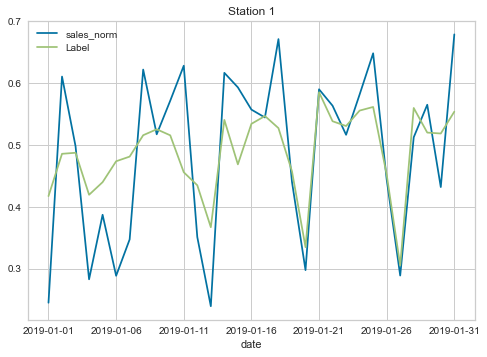

In [73]:
#split train and test
GOA1_train = GOA_train[GOA_train["station"]==1]
GOA1_test = GOA_test[GOA_test["station"]==1]

#perform setup and compare best model
setup_ES1 = setup(data = GOA1_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA1 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA1 = tune_model(best_GOA1, n_iter= numero)

#predict train, test and test without first January week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_1']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train1 = predict_model(best_GOA1, data= GOA1_train)
print(" ")
print('Testing set metrics')
predictions_test1 = predict_model(best_GOA1, data= GOA1_test)
predictions_test1_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test1_wo = predict_model(best_GOA1, data= GOA1_test.loc[GOA1_test.index>"2019-01-08"])

#plot predictions
predictions_test1[["sales_norm", "Label"]].plot(title='Station 1')

#### Tuned Model

In [74]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_1']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_1']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned1 = predict_model(tuned_model_GOA1, data= GOA1_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned1 = predict_model(tuned_model_GOA1, data= GOA1_test)
predictions_test_tuned1_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned1_wo = predict_model(tuned_model_GOA1, data= GOA1_test.loc[GOA1_test.index>"2019-01-08"])

Global model MAE: 0.06676613937117602 for the Testing set
 
Global GOA model MAE: 0.06249580459743115 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0739,0.0107,0.1032,0.6011,0.0677,0.2485


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0773,0.0087,0.0935,0.5162,0.0644,0.1894


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0632,0.0059,0.0765,0.6020,0.0507,0.1324


In [75]:
station_1_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_1'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_1'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_1'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_1'],6),
                    'Local Model, MAE =': round(predictions_test1_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned1_MAE['MAE'][0],6)}

In [76]:
station_1_scores

{'Global Model, MAE =': 0.066766,
 'Global Tuned Model, MAE =': 0.063526,
 'GOA Model, MAE =': 0.062496,
 'GOA Tuned Model, MAE =': 0.065153,
 'Local Model, MAE =': 0.0736,
 'Local Tuned Model, MAE =': 0.0773}

In [77]:
print("Lowest MAE for station 1, and therefore Best Model:", min(station_1_scores, key=station_1_scores.get), min(station_1_scores.values()))

Lowest MAE for station 1, and therefore Best Model: GOA Model, MAE = 0.062496


### Station 2

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0822,0.0106,0.1028,0.2860,0.0673,0.1672
1,0.1042,0.0222,0.1490,0.2059,0.1001,0.3144
2,0.0808,0.0148,0.1215,0.4298,0.0862,0.5381
3,0.0884,0.0161,0.1269,0.4401,0.0873,0.4061
4,0.0778,0.0105,0.1026,0.4499,0.0672,0.1609
5,0.1003,0.0234,0.1531,0.1133,0.1076,0.4312
6,0.0880,0.0173,0.1316,0.2972,0.0892,0.2396
7,0.0819,0.0108,0.1039,0.5156,0.0672,0.1655
8,0.1321,0.0326,0.1805,0.1464,0.1295,1.1977


Global GOA model MAE: 0.0857405519618649 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0241,0.0037,0.0607,0.8507,0.0405,0.1375


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1215,0.0251,0.1583,-0.1269,0.1176,0.5037


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1063,0.0215,0.1466,-0.7426,0.1068,0.2492


<AxesSubplot:title={'center':'Station 2'}, xlabel='date'>

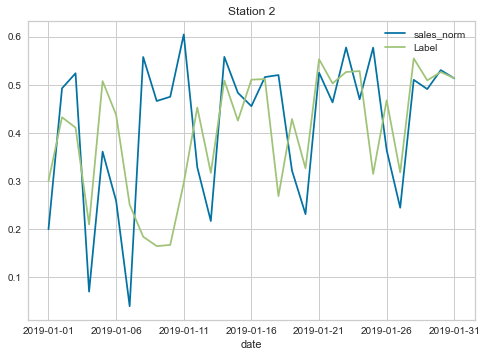

In [78]:
#split train and test
GOA2_train = GOA_train[GOA_train["station"]==2]
GOA2_test = GOA_test[GOA_test["station"]==2]

#perform setup and compare best model
setup_ES2 = setup(data = GOA2_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA2 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA2 = tune_model(best_GOA2, n_iter=numero)

#predict train, test and test withut first January week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_2']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train2 = predict_model(best_GOA2, data= GOA2_train)
print(" ")
print('Testing set metrics')
predictions_test2 = predict_model(best_GOA2, data= GOA2_test)
predictions_test2_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test2_wo = predict_model(best_GOA2, data= GOA2_test.loc[GOA2_test.index>"2019-01-08"])

#plot predictions
predictions_test2[["sales_norm", "Label"]].plot(title='Station 2')

#### Local Tuned Model

In [79]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_2']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_2']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned2 = predict_model(tuned_model_GOA2, data= GOA2_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned2 = predict_model(tuned_model_GOA2, data= GOA2_test)
predictions_test_tuned2_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned2_wo = predict_model(tuned_model_GOA2, data= GOA2_test.loc[GOA2_test.index>"2019-01-08"])

Global model MAE: 0.0850137719535799 for the Testing set
 
Global GOA model MAE: 0.0857405519618649 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0846,0.0148,0.1215,0.4014,0.0833,0.3945


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1142,0.0263,0.1621,-0.1815,0.1221,0.8877


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0822,0.0088,0.0940,0.2833,0.0667,0.2292


In [80]:
station_2_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_2'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_2'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_2'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_2'],6),
                    'Local Model, MAE =': round(predictions_test2_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned2_MAE['MAE'][0],6)}

In [81]:
station_2_scores

{'Global Model, MAE =': 0.085014,
 'Global Tuned Model, MAE =': 0.085683,
 'GOA Model, MAE =': 0.085741,
 'GOA Tuned Model, MAE =': 0.088026,
 'Local Model, MAE =': 0.1215,
 'Local Tuned Model, MAE =': 0.1142}

In [82]:
print("Lowest MAE for station 2, and therefore Best Model:", min(station_2_scores, key=station_2_scores.get), min(station_2_scores.values()))

Lowest MAE for station 2, and therefore Best Model: Global Model, MAE = 0.085014


### Station 3

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1098,0.0197,0.1402,0.1535,0.0954,0.2840
1,0.0902,0.0146,0.1207,0.1916,0.0862,0.3085
2,0.0908,0.0129,0.1136,0.2531,0.0788,0.2331
3,0.1016,0.0160,0.1264,0.2997,0.0896,0.3201
4,0.1003,0.0166,0.1288,0.3084,0.0901,0.2882
5,0.0957,0.0165,0.1284,0.2932,0.0903,0.3012
6,0.1006,0.0161,0.1270,0.2757,0.0864,0.2603
7,0.1084,0.0219,0.1481,0.1888,0.1023,0.3883
8,0.0758,0.0104,0.1021,0.4294,0.0705,0.2142


Global model MAE: 0.08730928308776838 for the Testing set
 
Global GOA model MAE: 0.08286286504135397 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0305,0.0062,0.0786,0.7382,0.0543,0.1382


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0780,0.0123,0.1107,0.3543,0.0799,0.2640


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0607,0.0061,0.0784,0.6088,0.0535,0.1399


<AxesSubplot:title={'center':'Station 3'}, xlabel='date'>

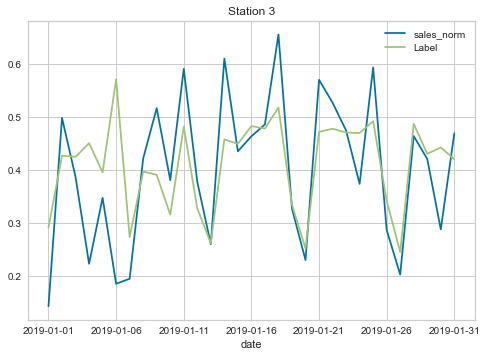

In [68]:
#split train and test
GOA3_train = GOA_train[GOA_train["station"]==3]
GOA3_test = GOA_test[GOA_test["station"]==3]

#perform setup and compare best model
setup_ES3 = setup(data = GOA3_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA3 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA3 = tune_model(best_GOA3, n_iter = numero)

#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_3']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_3']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train3 = predict_model(best_GOA3, data= GOA3_train)
print(" ")
print('Testing set metrics')
predictions_test3 = predict_model(best_GOA3, data= GOA3_test)
predictions_test3_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test3_wo = predict_model(best_GOA3, data= GOA3_test.loc[GOA3_test.index>"2019-01-08"])

#plot predictions
predictions_test3[["sales_norm", "Label"]].plot(title='Station 3')

#### Local Tuned Model

In [69]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_3']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_3']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned3 = predict_model(tuned_model_GOA3, data= GOA3_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned3 = predict_model(tuned_model_GOA3, data= GOA3_test)
predictions_test_tuned3_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned3_wo = predict_model(tuned_model_GOA3, data= GOA3_test.loc[GOA3_test.index>"2019-01-08"])

Global model MAE: 0.08730928308776838 for the Testing set
 
Global GOA model MAE: 0.08286286504135397 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0880,0.0150,0.1227,0.3620,0.0854,0.3279


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0811,0.0116,0.1077,0.3893,0.0794,0.2910


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0614,0.0059,0.0765,0.6277,0.0529,0.1562


In [70]:
station_3_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_3'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_3'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_3'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_3'],6),
                    'Local Model, MAE =': round(predictions_test3_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned3_MAE['MAE'][0],6)}

In [71]:
station_3_scores

{'Global Model, MAE =': 0.087309,
 'Global Tuned Model, MAE =': 0.083977,
 'GOA Model, MAE =': 0.082863,
 'GOA Tuned Model, MAE =': 0.082213,
 'Local Model, MAE =': 0.078,
 'Local Tuned Model, MAE =': 0.0811}

In [72]:
print("Lowest MAE for station 3, and therefore Best Model:", min(station_3_scores, key=station_3_scores.get), min(station_3_scores.values()))

Lowest MAE for station 3, and therefore Best Model: Local Model, MAE = 0.078


### Station 4

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0536,0.0042,0.0645,0.2447,0.0436,0.1161
1,0.0675,0.0123,0.1109,0.1498,0.0833,0.3484
2,0.0582,0.0083,0.0911,0.1855,0.0686,0.4048
3,0.0650,0.0079,0.0889,0.1311,0.0644,0.3161
4,0.0707,0.0108,0.1038,0.1514,0.0765,0.3210
5,0.0621,0.0082,0.0907,0.2948,0.0659,0.2146
6,0.0457,0.0035,0.0588,0.4042,0.0396,0.0972
7,0.0530,0.0066,0.0814,0.2150,0.0577,0.1645
8,0.0481,0.0039,0.0621,0.3696,0.0424,0.1035


Global GOA model MAE: 0.07534070609872759 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0197,0.0026,0.0509,0.7336,0.0357,0.0555


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0796,0.0105,0.1024,0.1298,0.0790,0.4710


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0715,0.0087,0.0933,-1.3372,0.0685,0.1736


<AxesSubplot:title={'center':'Station 4'}, xlabel='date'>

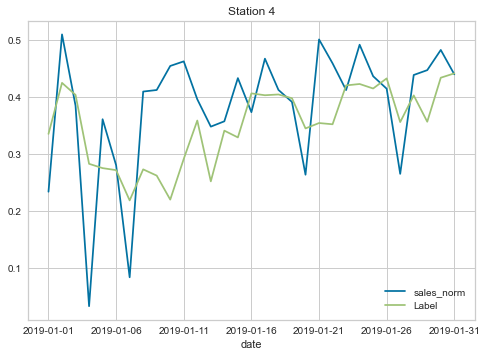

In [83]:
#split train and test
GOA4_train = GOA_train[GOA_train["station"]==4]
GOA4_test = GOA_test[GOA_test["station"]==4]

#perform setup and compare best model
setup_ES4 = setup(data = GOA4_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA4 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA4 = tune_model(best_GOA4, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_4']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train4 = predict_model(best_GOA4, data= GOA4_train)
print(" ")
print('Testing set metrics')
predictions_test4 = predict_model(best_GOA4, data= GOA4_test)
predictions_test4_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test4_wo = predict_model(best_GOA4, data= GOA4_test.loc[GOA4_test.index>"2019-01-08"])

#plot predictions
predictions_test4[["sales_norm", "Label"]].plot(title='Station 4')

#### Tuned Model

In [84]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_4']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_4']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned4 = predict_model(tuned_model_GOA4, data= GOA4_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned4 = predict_model(tuned_model_GOA4, data= GOA4_test)
predictions_test_tuned4_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned4_wo = predict_model(tuned_model_GOA4, data= GOA4_test.loc[GOA4_test.index>"2019-01-08"])

Global model MAE: 0.06727829783976805 for the Testing set
 
Global GOA model MAE: 0.07534070609872759 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0490,0.0057,0.0754,0.4144,0.0544,0.1799


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0737,0.0101,0.1004,0.1648,0.0786,0.5294


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0527,0.0046,0.0679,-0.2389,0.0491,0.1340


In [85]:
station_4_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_4'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_4'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_4'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_4'],6),
                    'Local Model, MAE =': round(predictions_test4_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned4_MAE['MAE'][0],6)}

In [86]:
station_4_scores

{'Global Model, MAE =': 0.067278,
 'Global Tuned Model, MAE =': 0.070654,
 'GOA Model, MAE =': 0.075341,
 'GOA Tuned Model, MAE =': 0.068837,
 'Local Model, MAE =': 0.0796,
 'Local Tuned Model, MAE =': 0.0737}

In [87]:
print("Lowest MAE for station 4, and therefore Best Model:", min(station_4_scores, key=station_4_scores.get), min(station_4_scores.values()))

Lowest MAE for station 4, and therefore Best Model: Global Model, MAE = 0.067278


### Station 5

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1672,0.0387,0.1966,0.0684,0.1344,0.4684
1,0.1341,0.0262,0.1619,0.4123,0.1086,0.3533
2,0.1283,0.0309,0.1759,0.3473,0.1178,0.3592
3,0.1394,0.0312,0.1766,0.2692,0.1205,0.3935
4,0.1091,0.0260,0.1614,0.3529,0.1070,0.2744
5,0.1290,0.0308,0.1755,0.3801,0.1187,0.3884
6,0.1115,0.0230,0.1517,0.3581,0.1041,0.3198
7,0.1013,0.0186,0.1363,0.5041,0.0911,0.2818
8,0.0964,0.0195,0.1398,0.4554,0.0957,0.2770


Global GOA model MAE: 0.12220928242004256 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0608,0.0085,0.0924,0.7970,0.0633,0.1742


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1328,0.0292,0.1710,0.5111,0.1116,0.3334


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1011,0.0169,0.1299,0.6857,0.0823,0.2135


<AxesSubplot:title={'center':'Station 5'}, xlabel='date'>

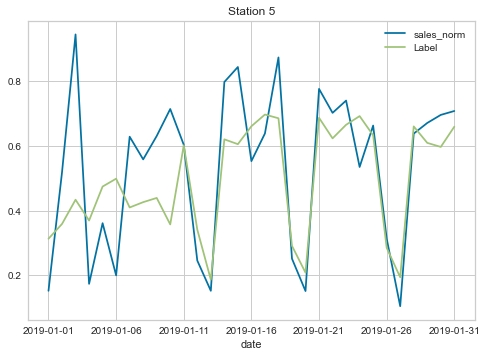

In [88]:
#split train and test
GOA5_train = GOA_train[GOA_train["station"]==5]
GOA5_test = GOA_test[GOA_test["station"]==5]

#perform setup and compare best model
setup_ES5 = setup(data = GOA5_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA5 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA5 = tune_model(best_GOA5, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_5']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train5 = predict_model(best_GOA5, data= GOA5_train)
print(" ")
print('Testing set metrics')
predictions_test5 = predict_model(best_GOA5, data= GOA5_test)
predictions_test5_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test5_wo = predict_model(best_GOA5, data= GOA5_test.loc[GOA5_test.index>"2019-01-08"])

#plot predictions
predictions_test5[["sales_norm", "Label"]].plot(title='Station 5')

#### Tuned model

In [89]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_5']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_5']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned5 = predict_model(tuned_model_GOA5, data= GOA5_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned5 = predict_model(tuned_model_GOA5, data= GOA5_test)
predictions_test_tuned5_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned5_wo = predict_model(tuned_model_GOA5, data= GOA5_test.loc[GOA5_test.index>"2019-01-08"])

Global model MAE: 0.13813826712182728 for the Testing set
 
Global GOA model MAE: 0.12220928242004256 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0961,0.0188,0.1370,0.5536,0.0933,0.2753


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.1128,0.0213,0.1459,0.6438,0.0945,0.2954


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0849,0.0105,0.1023,0.8051,0.0634,0.1896


In [90]:
station_5_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_5'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_5'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_5'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_5'],6),
                    'Local Model, MAE =': round(predictions_test5_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned5_MAE['MAE'][0],6)}

In [91]:
station_5_scores


{'Global Model, MAE =': 0.138138,
 'Global Tuned Model, MAE =': 0.12857,
 'GOA Model, MAE =': 0.122209,
 'GOA Tuned Model, MAE =': 0.128836,
 'Local Model, MAE =': 0.1328,
 'Local Tuned Model, MAE =': 0.1128}

In [92]:
print("Lowest MAE for station 5, and therefore Best Model:", min(station_5_scores, key=station_5_scores.get), min(station_5_scores.values()))

Lowest MAE for station 4, and therefore Best Model: Local Tuned Model, MAE = 0.1128


### Station 6

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1121,0.0244,0.1560,0.1219,0.1092,26.4320
1,0.0819,0.0145,0.1203,0.2697,0.0843,0.4481
2,0.0831,0.0152,0.1233,0.0693,0.0808,0.1930
3,0.0758,0.0118,0.1087,0.2215,0.0719,0.1855
4,0.0974,0.0219,0.1481,0.0596,0.1018,0.3476
5,0.0899,0.0162,0.1272,0.2545,0.0837,0.3668
6,0.0954,0.0260,0.1614,0.2058,0.1161,0.7823
7,0.0858,0.0183,0.1354,0.2509,0.0958,0.4489
8,0.0753,0.0102,0.1009,0.4330,0.0679,0.2411


Global GOA model MAE: 0.0897529456428456 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0248,0.0039,0.0627,0.8157,0.0403,0.0510


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0970,0.0192,0.1385,0.1755,0.0994,0.3957


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0704,0.0086,0.0929,0.1136,0.0597,0.1303


<AxesSubplot:title={'center':'Station 6'}, xlabel='date'>

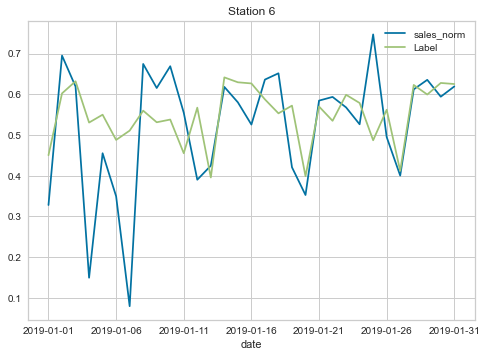

In [93]:
#split train and test
GOA6_train = GOA_train[GOA_train["station"]==6]
GOA6_test = GOA_test[GOA_test["station"]==6]

#perform setup and compare best model
setup_ES6 = setup(data = GOA6_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA6 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA6 = tune_model(best_GOA6, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_6']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train6 = predict_model(best_GOA6, data= GOA6_train)
print(" ")
print('Testing set metrics')
predictions_test6 = predict_model(best_GOA6, data= GOA6_test)
predictions_test6_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test6_wo = predict_model(best_GOA6, data= GOA6_test.loc[GOA6_test.index>"2019-01-08"])

#plot predictions
predictions_test6[["sales_norm", "Label"]].plot(title='Station 6')

#### Tuned Model

In [94]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_6']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_6']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned6 = predict_model(tuned_model_GOA6, data= GOA6_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned6 = predict_model(tuned_model_GOA6, data= GOA6_test)
predictions_test_tuned6_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned6_wo = predict_model(tuned_model_GOA6, data= GOA6_test.loc[GOA6_test.index>"2019-01-08"])

Global model MAE: 0.09221752287448982 for the Testing set
 
Global GOA model MAE: 0.0897529456428456 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0714,0.0113,0.1063,0.4704,0.0724,1.4867


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0978,0.0196,0.1401,0.1564,0.1008,0.4079


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0671,0.0073,0.0855,0.2500,0.0552,0.1278


In [95]:
station_6_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_6'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_6'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_6'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_6'],6),
                    'Local Model, MAE =': round(predictions_test6_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned6_MAE['MAE'][0],6)}

In [96]:
station_6_scores

{'Global Model, MAE =': 0.092218,
 'Global Tuned Model, MAE =': 0.088447,
 'GOA Model, MAE =': 0.089753,
 'GOA Tuned Model, MAE =': 0.085582,
 'Local Model, MAE =': 0.097,
 'Local Tuned Model, MAE =': 0.0978}

In [97]:
print("Lowest MAE for station 6, and therefore Best Model:", min(station_6_scores, key=station_6_scores.get), min(station_6_scores.values()))

Lowest MAE for station 6, and therefore Best Model: GOA Tuned Model, MAE = 0.085582


### Station 7

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0989,0.0169,0.1298,0.2883,0.0869,0.2364
1,0.0966,0.0170,0.1303,0.2651,0.0852,0.2058
2,0.1059,0.0167,0.1294,0.3375,0.0849,0.2292
3,0.0978,0.0187,0.1366,0.4756,0.0960,0.4142
4,0.0961,0.0206,0.1434,0.2629,0.1023,0.5899
5,0.0896,0.0133,0.1151,0.3824,0.0729,0.1656
6,0.0899,0.0132,0.1148,0.2854,0.0745,0.1729
7,0.1036,0.0194,0.1393,0.1349,0.0917,0.2677
8,0.0867,0.0154,0.1241,0.3937,0.0854,0.3175


Global GOA model MAE: 0.08449209365762486 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0299,0.0062,0.0790,0.7648,0.0547,0.1532


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0898,0.0135,0.1160,0.3981,0.0843,0.3967


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0663,0.0069,0.0831,0.4487,0.0551,0.1294


<AxesSubplot:title={'center':'Station 7'}, xlabel='date'>

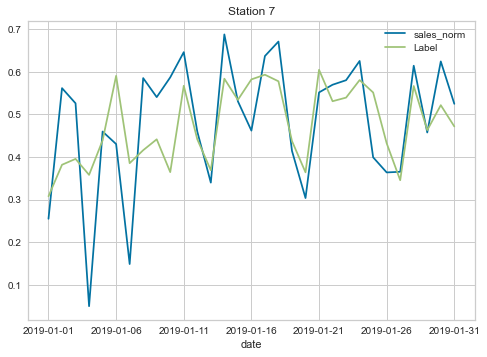

In [98]:
#split train and test
GOA7_train = GOA_train[GOA_train["station"]==7]
GOA7_test = GOA_test[GOA_test["station"]==7]

#perform setup and compare best model
setup_ES7 = setup(data = GOA7_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA7 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA7 = tune_model(best_GOA7, n_iter=numero)

#predict train, test and test withut first January week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_7']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train7 = predict_model(best_GOA7, data= GOA7_train)
print(" ")
print('Testing set metrics')
predictions_test7 = predict_model(best_GOA7, data= GOA7_test)
predictions_test7_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test7_wo = predict_model(best_GOA7, data= GOA7_test.loc[GOA7_test.index>"2019-01-08"])

#plot predictions
predictions_test7[["sales_norm", "Label"]].plot(title='Station 7')

#### Tuned Model

In [99]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_7']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_7']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned7 = predict_model(tuned_model_GOA7, data= GOA7_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned7 = predict_model(tuned_model_GOA7, data= GOA7_test)
predictions_test_tuned7_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned7_wo = predict_model(tuned_model_GOA7, data= GOA7_test.loc[GOA7_test.index>"2019-01-08"])

Global model MAE: 0.08183026103150154 for the Testing set
 
Global GOA model MAE: 0.08449209365762486 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0771,0.0128,0.1133,0.5171,0.0782,0.3200


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0871,0.0152,0.1231,0.3224,0.0915,0.4839


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0640,0.0061,0.0783,0.5109,0.0517,0.1317


In [100]:
station_7_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_7'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_7'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_7'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_7'],6),
                    'Local Model, MAE =': round(predictions_test7_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned7_MAE['MAE'][0],6)}

In [101]:
station_7_scores

{'Global Model, MAE =': 0.08183,
 'Global Tuned Model, MAE =': 0.083439,
 'GOA Model, MAE =': 0.084492,
 'GOA Tuned Model, MAE =': 0.089699,
 'Local Model, MAE =': 0.0898,
 'Local Tuned Model, MAE =': 0.0871}

In [102]:
print("Lowest MAE for station 7, and therefore Best Model:", min(station_7_scores, key=station_7_scores.get), min(station_7_scores.values()))

Lowest MAE for station 7, and therefore Best Model: Global Model, MAE = 0.08183


### Station 8

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1131,0.0217,0.1474,-0.1636,0.1029,1.1609
1,0.0828,0.0129,0.1136,0.1391,0.0838,0.3308
2,0.0807,0.0111,0.1055,0.3254,0.0788,0.3287
3,0.0843,0.0117,0.1081,0.2412,0.0801,0.5903
4,0.0863,0.0134,0.1158,0.3360,0.0851,0.3445
5,0.0952,0.0154,0.1242,0.3247,0.0938,1.1393
6,0.0785,0.0127,0.1127,0.1961,0.0805,0.2856
7,0.0989,0.0196,0.1400,0.2887,0.0982,0.7100
8,0.0623,0.0069,0.0833,0.5081,0.0593,0.1795


Global GOA model MAE: 0.07527993084382834 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0249,0.0037,0.0606,0.7933,0.0435,0.1043


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0674,0.0070,0.0835,0.4769,0.0627,0.2391


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0600,0.0054,0.0736,0.4679,0.0535,0.1705


<AxesSubplot:title={'center':'Station 8'}, xlabel='date'>

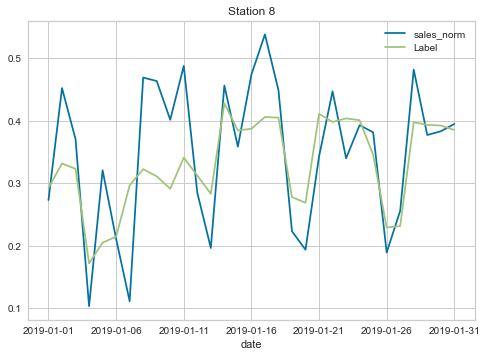

In [103]:
#split train and test
GOA8_train = GOA_train[GOA_train["station"]==8]
GOA8_test = GOA_test[GOA_test["station"]==8]

#perform setup and compare best model
setup_ES8 = setup(data = GOA8_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA8 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA8 = tune_model(best_GOA8, n_iter=numero)


#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_8']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train8 = predict_model(best_GOA8, data= GOA8_train)
print(" ")
print('Testing set metrics')
predictions_test8 = predict_model(best_GOA8, data= GOA8_test)
predictions_test8_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test8_wo = predict_model(best_GOA8, data= GOA8_test.loc[GOA8_test.index>"2019-01-08"])

#plot predictions
predictions_test8[["sales_norm", "Label"]].plot(title='Station 8')

#### Tuned Model

In [104]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_8']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_8']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned8 = predict_model(tuned_model_GOA8, data= GOA8_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned8 = predict_model(tuned_model_GOA8, data= GOA8_test)
predictions_test_tuned8_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned8_wo = predict_model(tuned_model_GOA8, data= GOA8_test.loc[GOA8_test.index>"2019-01-08"])

Global model MAE: 0.07719817322583673 for the Testing set
 
Global GOA model MAE: 0.07527993084382834 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0637,0.0079,0.0887,0.5573,0.0646,0.3702


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0694,0.0076,0.0873,0.4281,0.0668,0.2838


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0576,0.0051,0.0712,0.5028,0.0519,0.1695


In [105]:
station_8_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_8'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_8'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_8'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_8'],6),
                    'Local Model, MAE =': round(predictions_test8_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned8_MAE['MAE'][0],6)}

In [106]:
station_8_scores

{'Global Model, MAE =': 0.077198,
 'Global Tuned Model, MAE =': 0.07807,
 'GOA Model, MAE =': 0.07528,
 'GOA Tuned Model, MAE =': 0.075801,
 'Local Model, MAE =': 0.0674,
 'Local Tuned Model, MAE =': 0.0694}

In [107]:
print("Lowest MAE for station 8, and therefore Best Model:", min(station_8_scores, key=station_8_scores.get), min(station_8_scores.values()))

Lowest MAE for station 8, and therefore Best Model: Local Model, MAE = 0.0674


### Station 9

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0980,0.0226,0.1504,-0.0166,0.1054,0.9414
1,0.0856,0.0169,0.1301,0.1566,0.0884,0.3077
2,0.0915,0.0203,0.1426,0.1904,0.1008,0.8819
3,0.0842,0.0177,0.1329,0.1290,0.0926,0.3763
4,0.0914,0.0204,0.1430,0.1698,0.1011,0.6892
5,0.0719,0.0109,0.1046,0.2464,0.0666,0.1372
6,0.0683,0.0102,0.1011,0.3708,0.0695,23.7577
7,0.0685,0.0085,0.0924,0.3047,0.0570,0.1162
8,0.0582,0.0054,0.0734,0.5268,0.0449,0.0947


Global GOA model MAE: 0.07748245464895608 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0223,0.0042,0.0652,0.7695,0.0443,0.1288


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0994,0.0259,0.1608,-0.1748,0.1192,0.4240


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0839,0.0197,0.1403,-1.2634,0.1009,0.1505


<AxesSubplot:title={'center':'Station 9'}, xlabel='date'>

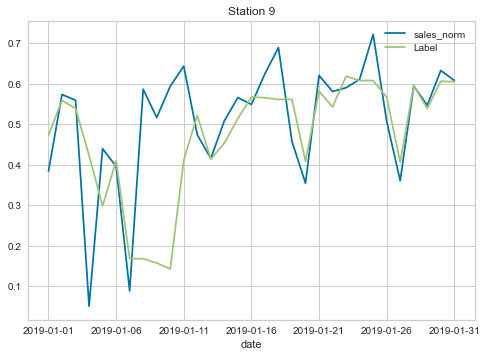

In [108]:
#split train and test
GOA9_train = GOA_train[GOA_train["station"]==9]
GOA9_test = GOA_test[GOA_test["station"]==9]

#perform setup and compare best model
setup_ES9 = setup(data = GOA9_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA9 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA9 = tune_model(best_GOA9, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_9']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train9 = predict_model(best_GOA9, data= GOA9_train)
print(" ")
print('Testing set metrics')
predictions_test9 = predict_model(best_GOA9, data= GOA9_test)
predictions_test9_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test9_wo = predict_model(best_GOA9, data= GOA9_test.loc[GOA9_test.index>"2019-01-08"])

#plot predictions
predictions_test9[["sales_norm", "Label"]].plot(title='Station 9')

#### Tuned Mode

In [109]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_9']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_9']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned9 = predict_model(tuned_model_GOA9, data= GOA9_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned9 = predict_model(tuned_model_GOA9, data= GOA9_test)
predictions_test_tuned9_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned9_wo = predict_model(tuned_model_GOA9, data= GOA9_test.loc[GOA9_test.index>"2019-01-08"])

Global model MAE: 0.07803522810314271 for the Testing set
 
Global GOA model MAE: 0.07748245464895608 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0656,0.0107,0.1036,0.4173,0.0710,1.2650


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0883,0.0208,0.1441,0.0567,0.1071,0.6048


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0541,0.0044,0.0660,0.4983,0.0435,0.1098


In [110]:
station_9_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_9'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_9'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_9'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_9'],6),
                    'Local Model, MAE =': round(predictions_test9_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned9_MAE['MAE'][0],6)}

In [111]:
station_9_scores

{'Global Model, MAE =': 0.078035,
 'Global Tuned Model, MAE =': 0.077035,
 'GOA Model, MAE =': 0.077482,
 'GOA Tuned Model, MAE =': 0.073893,
 'Local Model, MAE =': 0.0994,
 'Local Tuned Model, MAE =': 0.0883}

In [112]:
print("Lowest MAE for station 9, and therefore Best Model:", min(station_9_scores, key=station_9_scores.get), min(station_9_scores.values()))

Lowest MAE for station 9, and therefore Best Model: GOA Tuned Model, MAE = 0.073893


### Station 10

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0968,0.0157,0.1252,0.1960,0.0865,0.2839
1,0.0920,0.0151,0.1229,0.2688,0.0861,0.3183
2,0.0940,0.0156,0.1249,0.2278,0.0868,1.3005
3,0.0802,0.0160,0.1263,-0.0114,0.0845,0.2393
4,0.0777,0.0135,0.1162,0.3482,0.0828,0.3675
5,0.0857,0.0144,0.1200,0.1338,0.0820,0.6538
6,0.0949,0.0162,0.1274,0.1587,0.0877,0.2714
7,0.0754,0.0129,0.1138,0.2221,0.0779,0.2003
8,0.0953,0.0148,0.1215,0.2606,0.0822,0.2568


Global GOA model MAE: 0.08574446953551787 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0477,0.0057,0.0758,0.7004,0.0525,0.1916


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0960,0.0195,0.1397,0.2437,0.1052,0.7159


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0702,0.0104,0.1018,-0.1848,0.0676,0.1244


<AxesSubplot:title={'center':'Station 10'}, xlabel='date'>

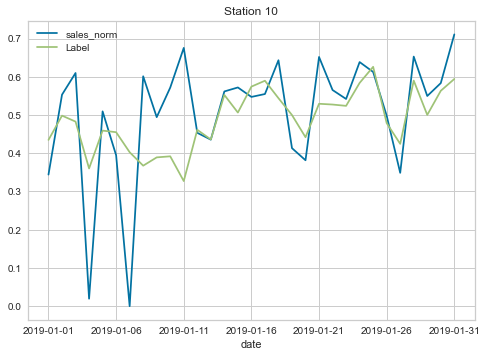

In [113]:
#split train and test
GOA10_train = GOA_train[GOA_train["station"]==10]
GOA10_test = GOA_test[GOA_test["station"]==10]

#perform setup and compare best model
setup_ES10 = setup(data = GOA10_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA10 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA10 = tune_model(best_GOA10, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_10']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train10 = predict_model(best_GOA10, data= GOA10_train)
print(" ")
print('Testing set metrics')
predictions_test10 = predict_model(best_GOA10, data= GOA10_test)
predictions_test10_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test10_wo = predict_model(best_GOA10, data= GOA10_test.loc[GOA10_test.index>"2019-01-08"])

#plot predictions
predictions_test10[["sales_norm", "Label"]].plot(title='Station 10')

#### Tuned Model

In [114]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_10']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_10']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned10 = predict_model(tuned_model_GOA10, data= GOA10_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned10 = predict_model(tuned_model_GOA10, data= GOA10_test)
predictions_test_tuned10_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned10_wo = predict_model(tuned_model_GOA10, data= GOA10_test.loc[GOA10_test.index>"2019-01-08"])

Global model MAE: 0.08247474267335304 for the Testing set
 
Global GOA model MAE: 0.08574446953551787 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0811,0.0133,0.1154,0.3052,0.0804,0.3765


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0862,0.0216,0.1470,0.1625,0.1134,0.9342


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,0.0529,0.0046,0.0675,0.4786,0.0436,0.0989


In [115]:
station_10_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_10'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_10'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_10'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_10'],6),
                    'Local Model, MAE =': round(predictions_test10_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned10_MAE['MAE'][0],6)}

In [116]:
station_10_scores

{'Global Model, MAE =': 0.082475,
 'Global Tuned Model, MAE =': 0.086984,
 'GOA Model, MAE =': 0.085744,
 'GOA Tuned Model, MAE =': 0.091687,
 'Local Model, MAE =': 0.096,
 'Local Tuned Model, MAE =': 0.0862}

In [117]:
print("Lowest MAE for station 10, and therefore Best Model:", min(station_10_scores, key=station_10_scores.get), min(station_10_scores.values()))

Lowest MAE for station 10, and therefore Best Model: Global Model, MAE = 0.082475


### Station 11

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0889,0.0143,0.1196,0.1970,0.0813,0.4205
1,0.0848,0.0129,0.1138,0.4027,0.0756,0.1321
2,0.0911,0.0183,0.1354,0.2259,0.0940,0.6241
3,0.0853,0.0142,0.1191,0.2558,0.0801,0.3681
4,0.0621,0.0071,0.0842,0.5569,0.0543,0.1183
5,0.0822,0.0134,0.1158,0.1150,0.0744,0.1597
6,0.0680,0.0089,0.0944,0.3822,0.0578,0.1111
7,0.0922,0.0130,0.1138,0.4057,0.0744,0.3122
8,0.0849,0.0152,0.1233,0.0543,0.0825,0.2988


Global GOA model MAE: 0.07775504378344947 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0272,0.0061,0.0780,0.7165,0.0555,0.3466


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1172,0.0205,0.1431,-0.0409,0.1058,2.1284


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0980,0.0155,0.1243,-1.0292,0.0862,0.2091


<AxesSubplot:title={'center':'Station 11'}, xlabel='date'>

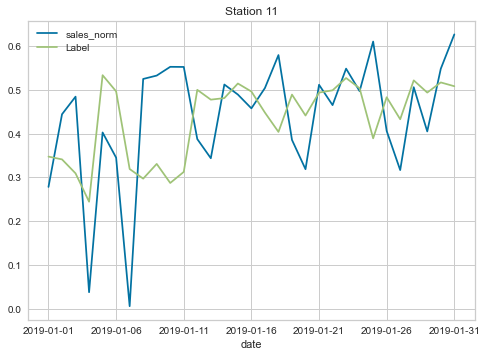

In [118]:
#split train and test
GOA11_train = GOA_train[GOA_train["station"]==11]
GOA11_test = GOA_test[GOA_test["station"]==11]

#perform setup and compare best model
setup_ES11 = setup(data = GOA11_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA11 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA11 = tune_model(best_GOA11, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_11']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train11 = predict_model(best_GOA11, data= GOA11_train)
print(" ")
print('Testing set metrics')
predictions_test11 = predict_model(best_GOA11, data= GOA11_test)
predictions_test11_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test11_wo = predict_model(best_GOA11, data= GOA11_test.loc[GOA11_test.index>"2019-01-08"])

#plot predictions
predictions_test11[["sales_norm", "Label"]].plot(title='Station 11')

#### Tuned Model

In [119]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_11']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_11']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned11 = predict_model(tuned_model_GOA11, data= GOA11_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned11 = predict_model(tuned_model_GOA11, data= GOA11_test)
predictions_test_tuned11_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned11_wo = predict_model(tuned_model_GOA11, data= GOA11_test.loc[GOA11_test.index>"2019-01-08"])

Global model MAE: 0.07685611273998162 for the Testing set
 
Global GOA model MAE: 0.07775504378344947 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0725,0.0114,0.1070,0.4661,0.0744,0.5184


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1016,0.0178,0.1335,0.0936,0.1018,2.7684


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0838,0.0103,0.1016,-0.3561,0.0695,0.1801


In [120]:
station_11_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_11'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_11'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_11'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_11'],6),
                    'Local Model, MAE =': round(predictions_test11_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned11_MAE['MAE'][0],6)}

In [121]:
station_11_scores

{'Global Model, MAE =': 0.076856,
 'Global Tuned Model, MAE =': 0.077829,
 'GOA Model, MAE =': 0.077755,
 'GOA Tuned Model, MAE =': 0.081034,
 'Local Model, MAE =': 0.1172,
 'Local Tuned Model, MAE =': 0.1016}

In [122]:
print("Lowest MAE for station 11, and therefore Best Model:", min(station_11_scores, key=station_11_scores.get), min(station_11_scores.values()))

Lowest MAE for station 10, and therefore Best Model: Global Model, MAE = 0.076856


### Station 12

#### Local Model

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.1262,0.0268,0.1637,0.0787,0.1050,0.3162
1,0.0770,0.0107,0.1035,0.4746,0.0629,0.1249
2,0.1242,0.0370,0.1925,0.0799,0.1310,0.8784
3,0.1027,0.0227,0.1506,0.2935,0.1012,0.6211
4,0.0781,0.0118,0.1087,0.4730,0.0713,0.2030
5,0.1027,0.0256,0.1599,0.3280,0.1075,0.5621
6,0.0966,0.0243,0.1560,0.3141,0.1102,2.0999
7,0.0842,0.0128,0.1130,0.4389,0.0700,0.1432
8,0.0875,0.0154,0.1243,0.4936,0.0840,0.3612


Global GOA model MAE: 0.0837104597399893 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0271,0.0049,0.0699,0.8416,0.0460,0.1766


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1065,0.0218,0.1478,0.2992,0.1084,1.0262


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0732,0.0087,0.0933,0.4082,0.0597,0.1324


<AxesSubplot:title={'center':'Station 12'}, xlabel='date'>

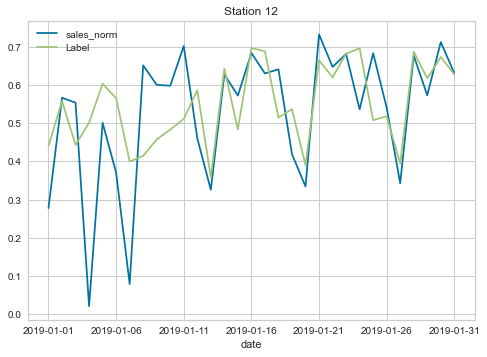

In [123]:
#split train and test
GOA12_train = GOA_train[GOA_train["station"]==12]
GOA12_test = GOA_test[GOA_test["station"]==12]

#perform setup and compare best model
setup_ES12 = setup(data = GOA12_train,  target = "sales_norm", fold_strategy = 'timeseries', silent= True) 
best_GOA12 = compare_models(sort="MAE", exclude = ["lar", "huber", "par", "llar", "knn", "lasso", "en"])
tuned_model_GOA12 = tune_model(best_GOA12, n_iter=numero)

#predict train, test and test withut first Jnuary week
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_12']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train12 = predict_model(best_GOA12, data= GOA12_train)
print(" ")
print('Testing set metrics')
predictions_test12 = predict_model(best_GOA12, data= GOA12_test)
predictions_test12_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test12_wo = predict_model(best_GOA12, data= GOA12_test.loc[GOA12_test.index>"2019-01-08"])

#plot predictions
predictions_test12[["sales_norm", "Label"]].plot(title='Station 12')

#### Tuned Model

In [124]:
#predict train, test and test withut first Jnuary week
print(f"Global model MAE: {d_global_maes['Global_MAE_12']} for the Testing set")
print(' ')
print(f"Global GOA model MAE: {d_global_GOA_maes['Global_GOA_MAE_12']} for the Testing set")
print(" ")
print('Training set metrics')
predictions_train_tuned12 = predict_model(tuned_model_GOA12, data= GOA12_train)
print(" ")
print('Testing set metrics')
predictions_test_tuned12 = predict_model(tuned_model_GOA12, data= GOA12_test)
predictions_test_tuned12_MAE = pull()
print(" ")
print('Testing set metrics without the first week')
predictions_test_tuned12_wo = predict_model(tuned_model_GOA12, data= GOA12_test.loc[GOA12_test.index>"2019-01-08"])

Global model MAE: 0.07933900423851754 for the Testing set
 
Global GOA model MAE: 0.0837104597399893 for the Testing set
 
Training set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0826,0.0144,0.1199,0.5335,0.0799,0.5207


 
Testing set metrics


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.1095,0.0211,0.1451,0.3248,0.1070,0.9599


 
Testing set metrics without the first week


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0794,0.0089,0.0944,0.3944,0.0610,0.1490


In [125]:
station_12_scores = {'Global Model, MAE =': round(d_global_maes['Global_MAE_12'],6),
                    'Global Tuned Model, MAE =': round(d_global_tuned_maes['Global_tuned_MAE_12'],6),
                    'GOA Model, MAE =': round(d_global_GOA_maes['Global_GOA_MAE_12'],6),
                    'GOA Tuned Model, MAE =': round(d_global_GOA_tuned_maes['Global_GOA_tuned_MAE_12'],6),
                    'Local Model, MAE =': round(predictions_test12_MAE['MAE'][0],6),
                    'Local Tuned Model, MAE =': round(predictions_test_tuned12_MAE['MAE'][0],6)}

In [126]:
station_12_scores

{'Global Model, MAE =': 0.079339,
 'Global Tuned Model, MAE =': 0.082398,
 'GOA Model, MAE =': 0.08371,
 'GOA Tuned Model, MAE =': 0.091169,
 'Local Model, MAE =': 0.1065,
 'Local Tuned Model, MAE =': 0.1095}

In [127]:
print("Lowest MAE for station 12, and therefore Best Model:", min(station_12_scores, key=station_12_scores.get), min(station_12_scores.values()))

Lowest MAE for station 10, and therefore Best Model: Global Model, MAE = 0.079339
